# General Import and install

In [1]:
!pip install gymnasium torch tqdm moviepy pygame


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import gymnasium as gym
import random
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

from collections import deque
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import pandas as pd

# for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [3]:
def plot_metrics(cumulative_rewards, num_steps, success_rates, param, string_param):
    """
    Function that plots the metrics.

    Parameters:
    - cumulative_rewards: List of cumulative rewards for each episode.
    - num_steps: List of number of steps taken for each episode.
    - success_rates: List of success rates for each episode. [0 if not succesful,1 otherwhise]
    - param: List of parameter values for each episode.
    - string_param: String representation of the parameter, used in the plot of the parameter
                    variation throuout the training.

    Returns:
    - None (plots the metrics with matplotlib).
    """

    # Create subplots
    fig, axs = plt.subplots(4, 1, figsize=(10, 15))

    # Cumulative rewards
    axs[0].plot(cumulative_rewards, label="actual data")
    axs[0].plot(rolling_average(cumulative_rewards, 100), label="rolling avg 100")
    axs[0].set_xlabel("Episode")
    axs[0].set_ylabel("Cumulative Reward")
    axs[0].set_title("Cumulative Reward per Episode")
    axs[0].legend()

    # number of steps taken by the agent per episode
    axs[1].plot(num_steps, label="actual data")
    axs[1].plot(rolling_average(num_steps, 100), label="rolling avg 100")
    axs[1].set_xlabel("Episode")
    axs[1].set_ylabel("Number of Steps")
    axs[1].set_title("Number of Steps per Episode")
    axs[1].legend()

    # Rolling Avg of success per episonde
    axs[2].plot(rolling_average(success_rates, 100))
    axs[2].set_xlabel("Episode")
    axs[2].set_ylabel("Rolling Avg of Success Rate")
    axs[2].set_title("Rolling Avg of Success Rate")

    # Value of the paramenter per episode
    axs[3].plot(param)
    axs[3].set_xlabel("Episode")
    axs[3].set_ylabel("Parameter")
    axs[3].set_title(f"Value of {string_param} per Episode")

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

In [4]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [5]:
#@title Rolling avg function
def rolling_average(data, window_size):
    """
    Computes the rolling average

    Parameters:
    - data: List of data points.
    - window_size: The size of the rolling window.

    Returns:
    - A list of rolling averages.
    """

    # Calculate the rolling averages
    rolling_averages = np.convolve(data, np.ones(window_size)/ window_size, 'valid')

    return rolling_averages.tolist()

In [6]:
#@title cumulative function
def cumulative(data, window_size):
    """
    Computes the cumulative sum

    Parameters:
    - data: List of data points.
    - window_size: The size of the rolling window.

    Returns:
    - A list of cumulative sums.
    """


    # Use a rolling window sum function
    result = np.convolve(data, np.ones(window_size), 'valid')

    return result.tolist()

# Tabular Q-learning

Here we tried to found the optimal action to the different states using tabular Q-Learning

For the tabular Q learing we explored 2 different policies to choos whether exploring or exploiting, the greedy policy and the softmax policy.



In [7]:
def show_env(env):
    plt.imshow(env.render())
    plt.axis('off')
    plt.show()

In [8]:
env = gym.make('Taxi-v3',render_mode="rgb_array")
env.time_limit = 200

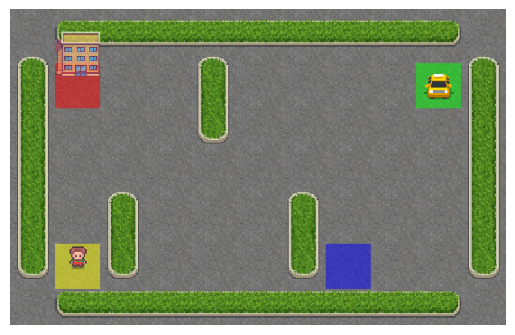

In [9]:
env.reset()
show_env(env)

In [10]:
# Initialize Q-table (state-action value table)
n_states = env.observation_space.n
n_actions = env.action_space.n
Q = torch.zeros(n_states, n_actions)

## Helper funtions

This functions are needed to help us and semplify the code later on

In [11]:
#@title Policy Greedy
def select_action_greedy(Q, state, episode, max_episodes, update_epsilon):
    """
    Selects an action using the epsilon-greedy policy.

    Parameters:
    - Q: The Q-table.
    - state: The current state.
    - episode: The current episode number (0-indexed).
    - max_episodes: The total number of episodes.
    - update_epsilon: A function that updates the epsilon value.

    Returns:
    - action: The selected action.
    """

    epsilon = update_epsilon(episode, max_episodes)

    if torch.rand(1).item() < epsilon:  # Exploration
        return env.action_space.sample()
    else:  # Exploitation
        return torch.argmax(Q[state]).item()


In [12]:
#@title decrease of epsilon greedy
def steady_decrease_epsilon(episode, max_episodes):
    return 1.0 - episode / max_episodes

In [13]:
#@title Softmax policy
def select_action_softmax(Q, state, episode, max_episodes, update_base):
    """
    Selects an action using the softmax policy.

    Parameters:
    - Q: The Q-table.
    - state: The current state.
    - episode: The current episode number (0-indexed).
    - max_episodes: The total number of episodes.
    - update_base: A function that updates the base value.

    Returns:
    - action: The selected action.

    """

    #probs = torch.nn.functional.softmax(Q[state], dim=0)

    base = update_base(episode, max_episodes)


    pow = torch.pow(base, Q[state])
    probs = pow / torch.sum(pow)

    return torch.multinomial(probs, 1).item()


In [14]:
#@title Esponential decrease
def dynamic_base(episode, max_episodes, initial_base=20, min_base=math.e, decay_rate=0.20):
    """
    Returns the base (or temperature) for the softmax policy depending on the current episode.

    Parameters:
    - episode: The current episode number (0-indexed).
    - max_episodes: The total number of episodes.
    - initial_base: The initial base (or temperature) at the start of training.
    - min_base: The minimum base (or temperature) to avoid it going too low.
    - decay_rate: The rate at which the base decays.

    Returns:
    - base: The base value for the softmax policy.
    """
    # Calculate the decayed base value
    base = initial_base * (decay_rate ** (episode / max_episodes))

    # Ensure the base doesn't fall below the minimum allowed value
    return max(base, min_base)

In [15]:
#@title Rolling avg function
def rolling_average(data, window_size):
    """
    Computes the rolling average

    Parameters:
    - data: List of data points.
    - window_size: The size of the rolling window.

    Returns:
    - A list of rolling averages.
    """

    # Calculate the rolling averages
    rolling_averages = np.convolve(data, np.ones(window_size)/ window_size, 'valid')

    return rolling_averages.tolist()

### Training functions

Here is the main function that trains the table

In [16]:
#@title Training function for Tabular Q learning
def training(num_episodes, F_policy, F_update_p, alpha, gamma, string_param, max_steps = 300):
    """
    Trains the Q-learning agent.

    Parameters:
    - num_episodes: max number of episodes for the training
    - F_policy : function that selects the policy the action.
    - F_update_p : function that updates the parameters of the policy.
    - alpha : Hyperparameter for the learning rate.
    - gamma : Hyperparameter for the discount factor.
    - early_stopping : Boolean flag indicating whether early stopping is enabled.

    Returns:
    - cumulative_rewards: List of cumulative rewards for each episode.
    - num_steps: List of number of steps taken for each episode.
    - success_rates: List of success rates for each episode. [0 if not succesful,1 otherwhise]
    """

    # Initialize Q-table (state-action value table)
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = torch.zeros(n_states, n_actions)

    print("The Q table is in:", Q.device)

    # Metrics
    cumulative_rewards = []
    success_rates = []
    num_steps = []

    print(f"Training for :{num_episodes:} Episodes")
    # for loop for the episods
    for episode in tqdm(range(num_episodes)):

        # Reset the environment and get the initial state
        state, _ = env.reset()

        # Reset the cumulative reward for the episode
        temp_cum_reward = 0

        for step in range(max_steps):

            # choose the action according the function it was given and update
            # the paramenter for the policy
            action = F_policy(Q, state, episode, num_episodes, F_update_p)

            # Execute the action
            next_state, reward, done, truncated, _ = env.step(action)

            # update Q
            Q[state,action] = (1-alpha)*Q[state,action] + alpha*(reward + gamma*torch.max(Q[next_state]))

            # next state
            state = next_state

            # metrics - cumulative reward
            temp_cum_reward += reward

            # stop if we are done or we are over the limit
            if done or truncated:
                break

        # metrics - append data of the episode
        cumulative_rewards.append(temp_cum_reward)
        if done:
            success_rates.append(1)
        else:
            success_rates.append(0)
        num_steps.append(step)


    # Plot the metrics
    plot_metrics(cumulative_rewards, num_steps, success_rates,
     [F_update_p(i, max_steps) for i in range(max_steps)], string_param)

    return Q

In [17]:
#@title Test function
def test_q(Q, num_episodes,nameAgent):
    env_video = gym.wrappers.RecordVideo(env, video_folder='video_'+nameAgent, episode_trigger=lambda x: True)
    for episode in range(num_episodes):
        state, _ = env_video.reset()
        done = False
        truncated = False
        total_reward = 0
        env_video.render()

        while not (done or truncated):
            action = torch.argmax(Q[state]).item()
            next_state, reward, done, truncated, _ = env_video.step(action)
            total_reward += reward
            state = next_state

            env_video.render()

        print(f"Episode: {episode}, Total reward: {total_reward}")


## Greedy

### Steady Deacrease of Epsilon

The Q table is in: cpu
Training for :10000 Episodes


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 230.09it/s]


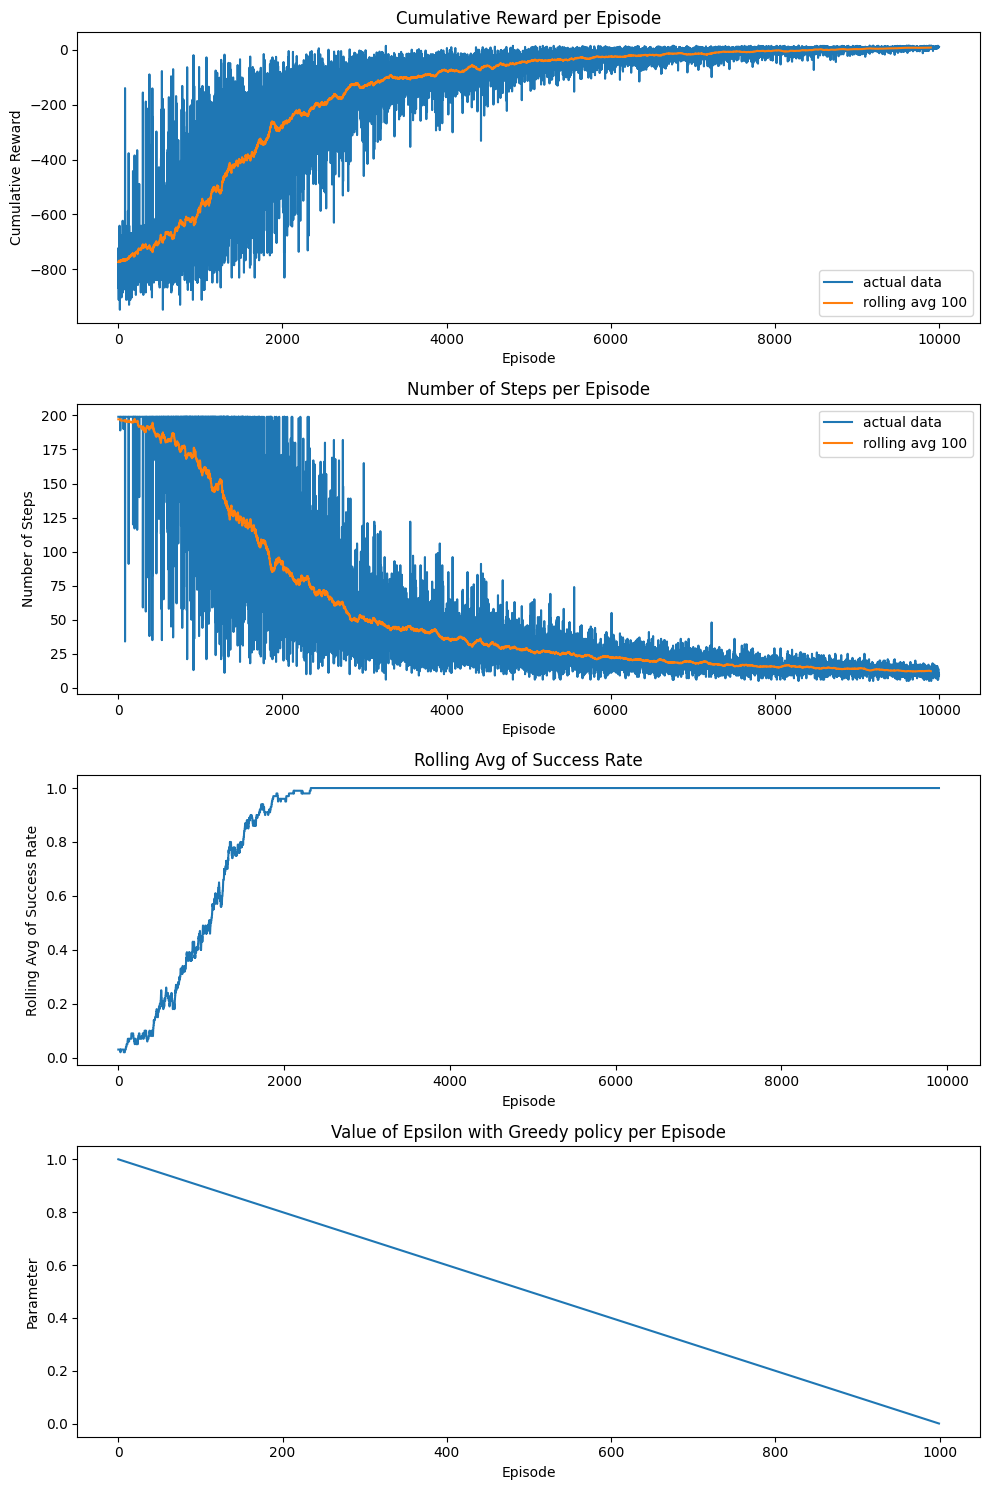

In [18]:
# Hyperparameters
alpha = 0.1      # Learning rate
gamma = 0.80     # Discount factor

num_episodes = 10_000
max_steps = 1000   # Max steps per episode
Q = training(num_episodes, select_action_greedy, steady_decrease_epsilon, alpha, gamma, "Epsilon with Greedy policy")

Testing if the agent has learned the Best policy

In [19]:
test_q(Q, 10, "Greedy")

Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-0.mp4
Episode: 0, Total reward: 9


Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-1.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-1.mp4
Episode: 1, Total reward: 7


Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-2.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-2.mp4
Episode: 2, Total reward: 6


Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-3.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-3.mp4
Episode: 3, Total reward: 8
Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-4.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-4.mp4
Episode: 4, Total reward: 10
Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-5.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-5.mp4
Episode: 5, Total reward: 6


Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-6.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-6.mp4
Episode: 6, Total reward: 10


Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-7.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-7.mp4
Episode: 7, Total reward: 10
Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-8.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-8.mp4
Episode: 8, Total reward: 8
Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-9.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Greedy\rl-video-episode-9.mp4
Episode: 9, Total reward: 11


## Softmax

### Dynamic base softmax

The Q table is in: cpu
Training for :10000 Episodes


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:39<00:00, 255.25it/s]


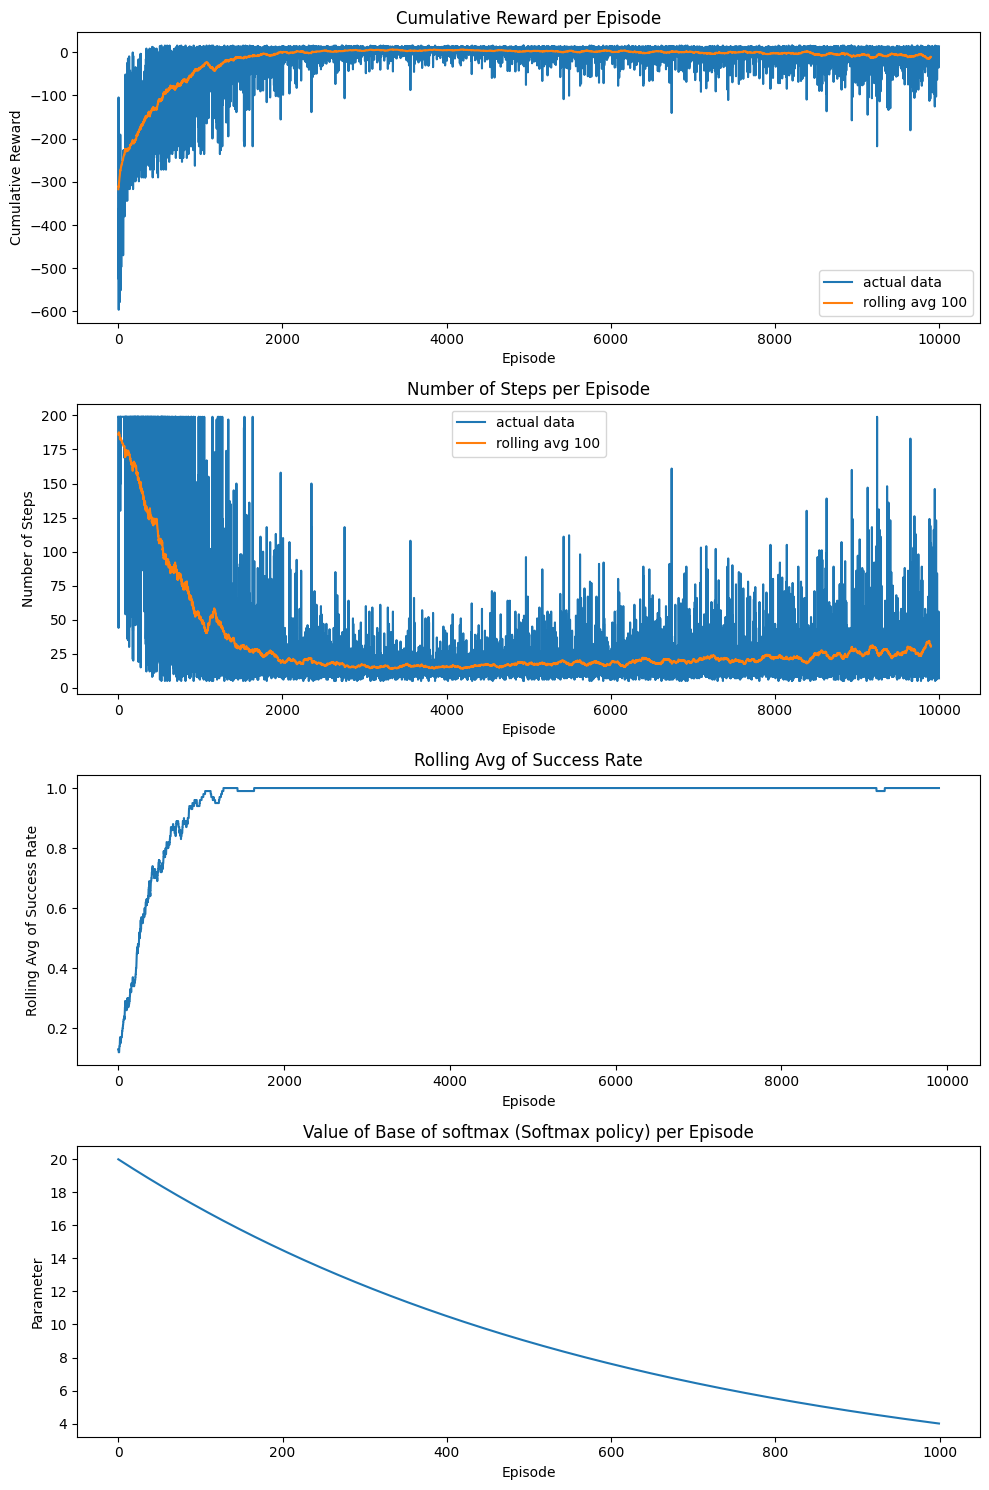

In [20]:
# Hyperparameters
alpha = 0.1      # Learning rate
gamma = 0.80     # Discount factor

num_episodes = 10_000
max_steps = 1000   # Max steps per episode
Q = training(num_episodes, select_action_softmax, dynamic_base, alpha, gamma, "Base of softmax (Softmax policy)")

Here we did with just 4_000 episodes, because we saw that after some time, using the softmax policy, the number of steps taken by the agnet increased and the cumulative reward decreased

The Q table is in: cpu
Training for :4000 Episodes


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:24<00:00, 160.90it/s]


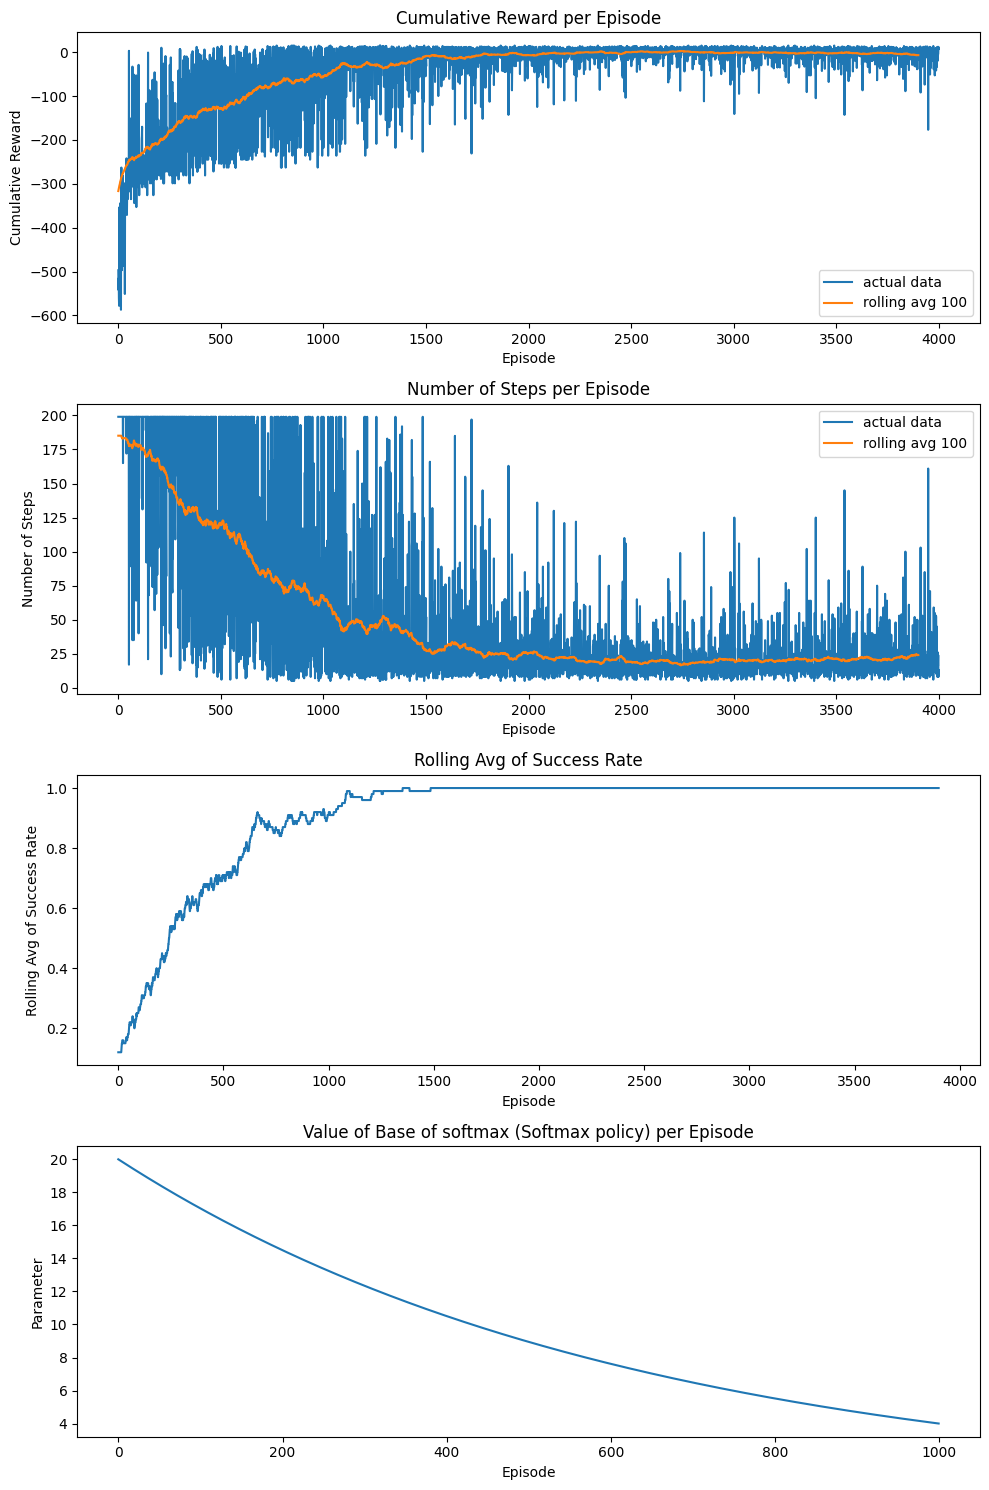

In [21]:
# Hyperparameters
alpha = 0.1      # Learning rate
gamma = 0.80     # Discount factor

num_episodes = 4_000
max_steps = 1000   # Max steps per episode
Q = training(num_episodes, select_action_softmax, dynamic_base, alpha, gamma, "Base of softmax (Softmax policy)")

In [22]:
test_q(Q, 10, "Softmax")

Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-0.mp4
Episode: 0, Total reward: 10


Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-1.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-1.mp4
Episode: 1, Total reward: 4


Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-2.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-2.mp4
Episode: 2, Total reward: 6


Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-3.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-3.mp4
Episode: 3, Total reward: 4


Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-4.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-4.mp4
Episode: 4, Total reward: 3


Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-5.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-5.mp4
Episode: 5, Total reward: 4


Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-6.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-6.mp4
Episode: 6, Total reward: 9


Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-7.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-7.mp4
Episode: 7, Total reward: 8
Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-8.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-8.mp4
Episode: 8, Total reward: 9


Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-9.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_Softmax\rl-video-episode-9.mp4
Episode: 9, Total reward: 5


# DQN

Here we wrote the Deep Q-Learing, we used a simple neural network, and we used ReLU as our activation functions for the network.

In [23]:
#@title Replay memory
# Replay memory
# We used a Deque becuse it allowed us to not think about overflowing as the
# library will take care of it, We wrote a sample_D that is used to get the batches
# of the replay memory as if they are aloready passed throw a Dataloader
class ReplayMemory:
    """
    Replay memory class.

    Parameters:
    - capacity: Maximum number of transitions to store.
    """

    def __init__(self, capacity, device):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)
        self.device = device


    def push(self, state:int, action:int, next_state:int, reward:int, done:bool, truncated:bool):

        self.memory.append((state, action, next_state, reward, done, truncated))

    def sample_D(self, batch_size):
        """
        Samples a batch of transitions from the replay memory.
        D stands for Dataloader since it already gives a tuple of :
            (states[batchsize], q_values[batchsize])

        Parameters:
        - batch_size: Number of transitions to sample.

        Returns:
        - A tuple of (states, actions, rewards, dones, next_states). all elements are tensors.

        """


        batch = random.sample(self.memory, batch_size)
        states, actions, next_states, rewards, dones, truncated = zip(*batch)


        return (
            torch.Tensor(states).to(self.device),
            torch.Tensor(actions).to(self.device),
            torch.Tensor(rewards).to(self.device),
            torch.Tensor(dones).to(self.device),
            torch.Tensor(truncated).to(self.device),
            np.array(next_states),
        )


    def sample(self, batch_size):
        """
        Samples a batch of transitions from the replay memory.

        Parameters:
        - batch_size: Number of transitions to sample.

        Returns:
        - A list of transitions (state, action, reward, next_state, done).
        """

        indices = np.random.choice(len(self.memory), batch_size, replace=False)
        return [self.memory[idx] for idx in indices]


    def __len__(self):
        return len(self.memory)

    def __getitem__(self, idx):
        return self.memory[idx]

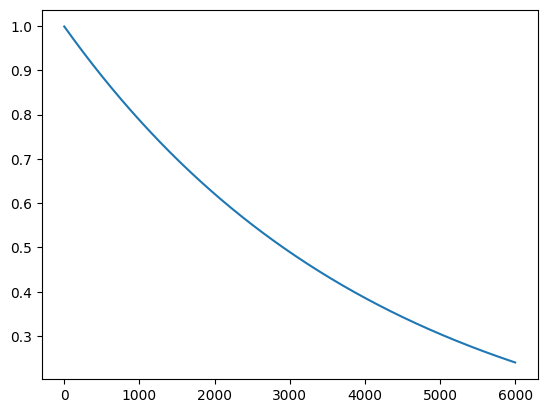

In [24]:
# Here is How the parameter Epsilon change during the 6_000 episodes that we do
plt.plot([0.001 + (0.999 - 0.001) * math.exp(-1. * episode / (6_000*0.7)) for episode in range(6_000)])
plt.show()

In [25]:
#@title NN
class DQN_multiple(nn.Module):
    """
    Deep Q-Network (DQN) class.
    Simple neural network with one hidden layer.

    Parameters:
    - state_dim: Dimension of the state space.
    - action_dim: Dimension of the action space.
    """
    def __init__(self,
                 state_dim,
                 action_dim,
                 device="cpu"):

        super(DQN_multiple, self).__init__()

        self.state_dim = state_dim

        self.model = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        ).to(device)
        self.device = device



    def forward(self, x):
        """
        Forward pass of the neural network.

        Parameters:
        - x: Input tensor.

        Returns:
        - Output tensor.
        """
        # Move and prepare the states
        if not torch.is_tensor(x):
            x = torch.tensor(x)

        x = x.long()
        # make them onehot encoding
        x = torch.nn.functional.one_hot(x, num_classes=self.state_dim)
        x = x.float()
        x = x.to(self.device)

        return self.model(x)



    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path))



In [26]:
#@title Agent: single nn
class Agent:

    def __init__(self,
                 learning_rate,
                 gamma,
                 num_episodes,
                 replay_capacity,
                 batch_size,
                 test_size=10,
                 device="cpu",
                 weight_decay=1e-4,
                 ):
        # Creation of Gym env
        self.env = gym.make('Taxi-v3',render_mode="rgb_array")

        self.dqn_model = DQN_multiple(self.env.observation_space.n,
                                      self.env.action_space.n,
                                      device=device)



        self.replay_memory = ReplayMemory(replay_capacity, device=device)

        # hyperparameters
        self.gamma = gamma
        self.num_episodes = num_episodes
        self.replay_capacity = replay_capacity
        self.batch_size = batch_size

        self.test_size = test_size

        # simple dictionary that stores the values per each episode
        self.metrics = {"loss":[],
                        "cumulative_rewards": [],
                        "num_steps": [],
                        "success_rates": [],
                        "value of epsilon": []}

        self.loss = nn.MSELoss()

        self.optimizer = optim.Adam(self.dqn_model.parameters(), lr=learning_rate)

        # option to add weight decay
        #self.optimizer = optim.Adam(self.dqn_model.parameters(), lr=learning_rate,
        #                            weight_decay=weight_decay)

        self.device = device


    def set_test_size(self, test_size):
        self.test_size = test_size

    def greedy_dqn(self, state, episode, max_episodes):
        """
        Selects an action using the epsilon-greedy policy.

        Parameters:
        - state: The current state.
        - episode: The current episode number (0-indexed).
        - max_episodes: The total number of episodes.

        Returns:
        - action: The selected action.
        - epsilon: The current value of epsilon. (useful later to graph it)
        """
        EPS_START = 0.999
        EPS_END = 0.001
        EPS_DECAY = max_episodes*0.7

        epsilon =  EPS_END + (EPS_START - EPS_END) * math.exp(-1. * episode / EPS_DECAY)

        # Explore
        if np.random.rand() < epsilon:
            action = self.env.action_space.sample()

        # Exploit
        else:
            # here we are using the nn, but we do not want to backpropagate
            # so we specify torch.no_grad
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.int64)
                q_values = self.dqn_model(state)
                action = torch.argmax(q_values).item()

        return action, epsilon

    # simple function to show the current state of the env
    def im_env(self):
        plt.imshow(self.env.render())
        plt.axis('off')
        plt.show()

    def optimize(self, batch):

        states, actions, rewards, dones, truncates, next_states = batch

        self.optimizer.zero_grad()

        # masrk of the final state, since next_state is always in range(600) but it is -1
        # when it is finished or trunketed == -2
        non_final_mask = [next_states >=0 ]
        # the values of all the non final states
        non_final_next_states = torch.Tensor(next_states[next_states >=0]).to(self.device)

        # calculate the explected best action using the nn target
        # we put penalty as default
        q_expected = torch.zeros(self.batch_size).to(self.device)

        # calculated the estimate for the q table
        q_values = self.dqn_model(states).gather(1, actions.long().unsqueeze(1))

        # here we do not want to accumulate gradient, we use the nn as a table
        with torch.no_grad():
            q_expected[non_final_mask] = self.dqn_model(non_final_next_states).max(1).values

        # Compute the expected Q values, using gamma update rules and rewards
        q_expected = (q_expected * self.gamma) + rewards


        # loss
        loss = self.loss(q_values, q_expected.unsqueeze(1))

        # backprop
        loss.backward()

        # In-place gradient clipping (to avoid expoding gradient)
        torch.nn.utils.clip_grad_value_(self.dqn_model.parameters(), 100)

        # Adjust learning weights
        self.optimizer.step()

        return loss.item()


    def train(self):
        # training loop
        for episode in tqdm(range(num_episodes)):
            state, info = self.env.reset()
            done = False
            truncated = False
            total_reward = 0
            l=0


            for __ in range(200):
                # Select the action (epsilon is just a nice to have)
                action, epsilon = self.greedy_dqn(state, episode, num_episodes)

                #print(f"Episode: {episode}, Action: {action}")

                # Execute the action
                next_state, reward, done, truncated, _ = self.env.step(action)
                total_reward += reward

                # we decided to represent -1 as the None next_state
                if done or truncated:
                    next_state = -1


                # Store in replay memory
                self.replay_memory.push(state, action, next_state, reward, done, truncated)

                if done or truncated:
                    break

                state = next_state

            # if we have enough elements in the memory we train the nn
            if len(self.replay_memory) >= self.batch_size:
                batch = self.replay_memory.sample_D(self.batch_size)
                l = self.optimize(batch)

            #print(f"Episode: {episode}, Total reward: {total_reward}", end="\r")

            # Append Metrics
            self.metrics["cumulative_rewards"].append(total_reward)
            if done:
                self.metrics["success_rates"].append(1)
            else:
                self.metrics["success_rates"].append(0)

            self.metrics["num_steps"].append(__)
            self.metrics["loss"].append(l)
            self.metrics["value of epsilon"].append(epsilon)

    def plot_metrics(self):
        # 5 different subplots for the cumulative reward, success rate and number of steps
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 15))

        # Plot the Loss
        ax1.plot(self.metrics["loss"], label="loss")
        ax1.plot(cumulative(self.metrics["loss"], 100), label="cumulative loss over 100 episodes")
        ax1.legend()
        ax1.set_title("Loss")
        ax1.set_xlabel("Episode")
        ax1.set_ylabel("Loss")

        # Plot the cumulative reward
        ax2.plot(self.metrics["cumulative_rewards"], label="cumulative reward per episode")
        ax2.plot(rolling_average(self.metrics["cumulative_rewards"], 100), label="reward moving average over 100 episodes")
        ax2.legend()
        ax2.set_title("Cumulative Reward")
        ax2.set_xlabel("Episode")
        ax2.set_ylabel("Reward")

        # Plot the success rate
        ax3.plot(self.metrics["success_rates"], label="success rate per episode")
        ax3.plot(rolling_average(self.metrics["success_rates"], 100), label="success rate moving average over 100 episodes")
        ax3.legend()
        ax3.set_title("Success Rate")
        ax3.set_xlabel("Episode")
        ax3.set_ylabel("Success Rate")

        # Plot the number of steps
        ax4.plot(self.metrics["num_steps"], label="number of steps taken per episode")
        ax4.plot(rolling_average(self.metrics["num_steps"], 100), label="number of steps moving average over 100 episodes")
        ax4.legend()
        ax4.set_title("Number of Steps")
        ax4.set_xlabel("Episode")
        ax4.set_ylabel("Number of Steps")

        # Plot the Value of Epsilon
        ax5.plot(self.metrics["value of epsilon"])
        ax5.set_title("Value of epsilon")
        ax5.set_xlabel("Episode")
        ax5.set_ylabel("Value of epsilon")


        plt.tight_layout()
        plt.show()

    def save_csv_metrics(self, path):
        df = pd.DataFrame(self.metrics)
        df.to_csv(path)

    def load_csv_metrics(self, path):
        self.metrics = pd.read_csv(path)

    def save_model(self, path):
        torch.save(self.dqn_model.state_dict(), path)

    def load_model(self, path):
        self.dqn_model.load_state_dict(torch.load(path))

    def return_metrics(self):
        return self.metrics

    # This function is to visually test the model
    # it will print the varius fram of the Agent playing the game
    def test_visual(self):
        env_video = gym.wrappers.RecordVideo(self.env, video_folder='video_DQN', episode_trigger=lambda x: True)
        for episode in range(self.test_size):
            state, _ = env_video.reset(seed=episode)
            done = False
            truncated = False
            total_reward = 0
            env_video.render()

            while not (done or truncated):
                action = torch.argmax(self.dqn_model(state)).item()
                next_state, reward, done, truncated, _ = env_video.step(action)
                total_reward += reward
                state = next_state

                env_video.render()

            print(f"Episode: {episode}, Total reward: {total_reward}")

    # this function is to test how reliable is the model
    # it will just get the varius metrics just using the Policy network
    def test_relay(self):

        self.metrics = {"loss":[],
                        "cumulative_rewards": [],
                        "num_steps": [],
                        "success_rates": [],
                        "value of epsilon": []}


        with torch.no_grad():
            for episode in tqdm(range(self.test_size)):
                state, _ = self.env.reset()
                done = False
                truncated = False
                total_reward = 0


                for __ in range(500):

                    action = torch.argmax(self.dqn_model(state)).item()
                    next_state, reward, done, truncated, _ = self.env.step(action)
                    total_reward += reward
                    state = next_state

                    if done or truncated:
                        break



                self.metrics["cumulative_rewards"].append(total_reward)
                if done:
                    self.metrics["success_rates"].append(1)
                else:
                    self.metrics["success_rates"].append(0)

                self.metrics["num_steps"].append(__)
                self.metrics["loss"].append(0)
                self.metrics["value of epsilon"].append(0)

    # Simple function that ges the mean
    def cal_mean(self):
        """
        Returns:
        - A tuple of (success_rate, cumulative_reward, num_steps)
        """
        return (np.mean(self.metrics["success_rates"]),
            np.mean(self.metrics["cumulative_rewards"]),
            np.mean(self.metrics["num_steps"]) )



In [27]:
#@title Training
learning_rate = 0.001
gamma = 0.999
num_episodes = 50_000
replay_capacity = 10_000
batch_size = 128

agent = Agent(learning_rate, gamma, num_episodes, replay_capacity, batch_size, device=device)
agent.train()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [06:22<00:00, 130.73it/s]


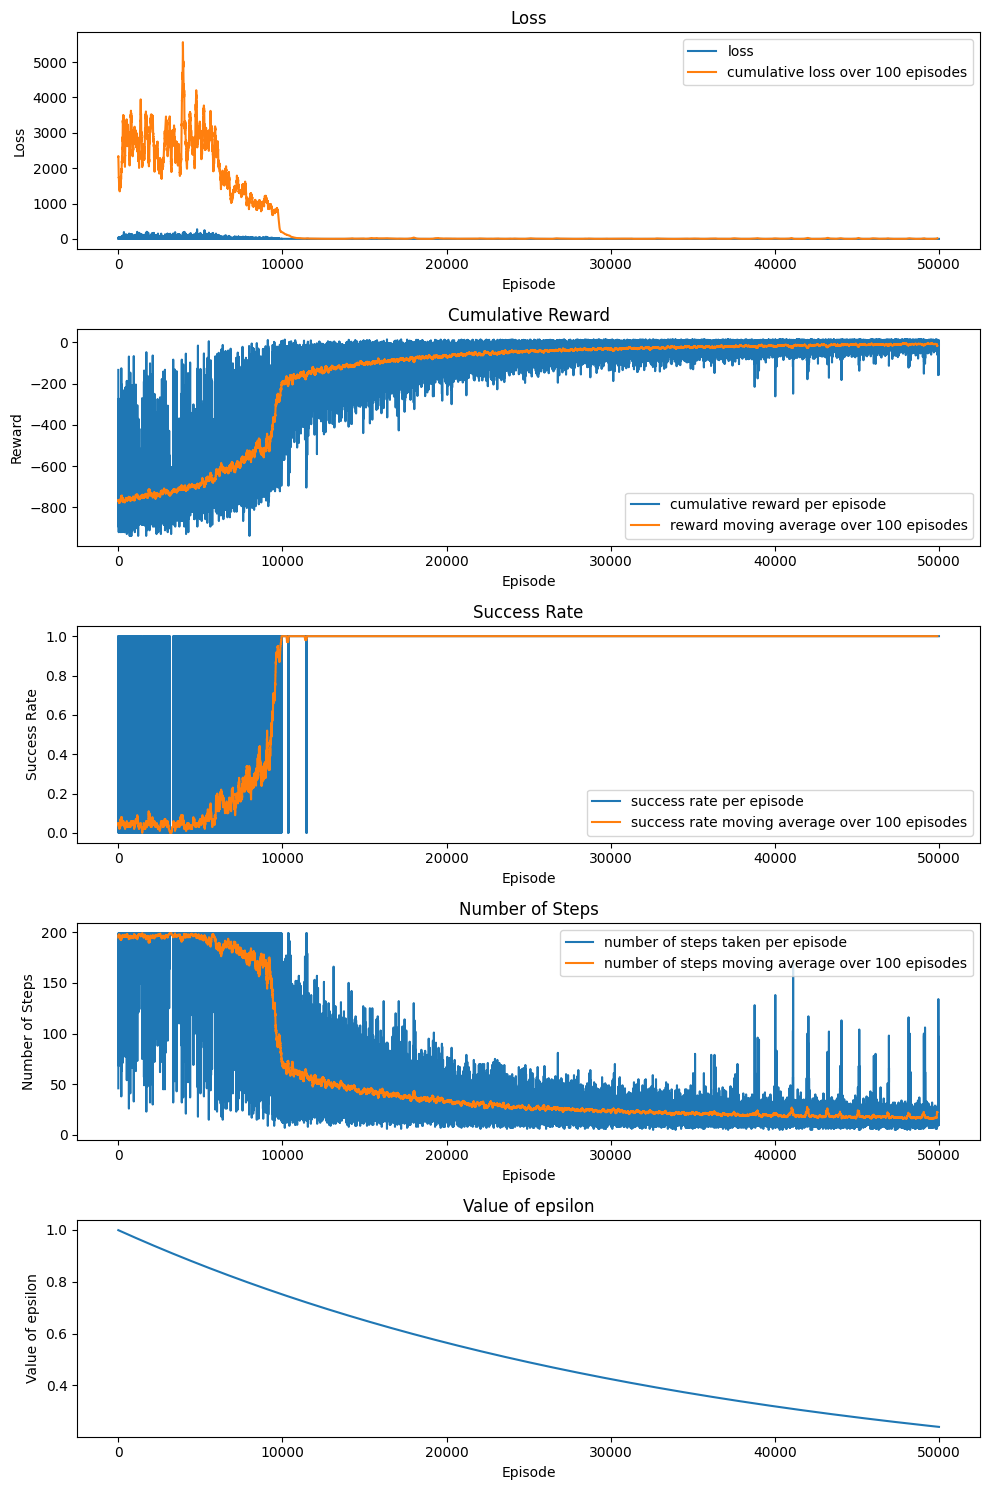

In [28]:
agent.save_csv_metrics("metrics.csv")
agent.save_model("model.pth")
agent.plot_metrics()

C:\Users\aless\AppData\Local\Temp\ipykernel_11808\2847318224.py:244: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.dqn_model.load_state_dict(torch.load(path))


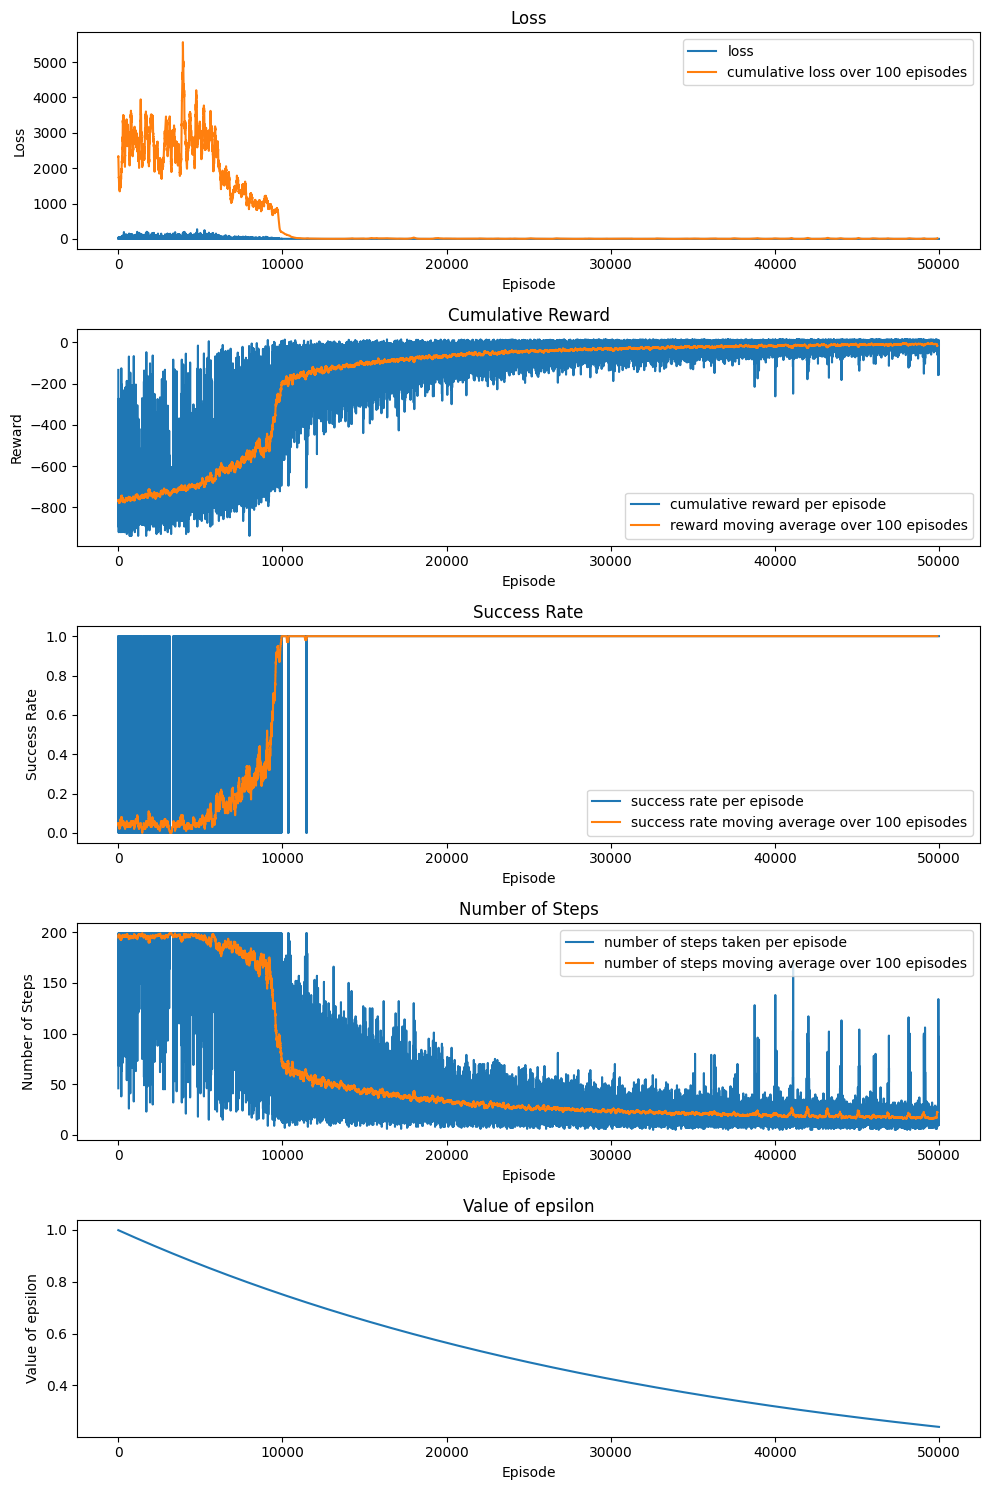

In [29]:
learning_rate = 0.001
gamma = 0.999
num_episodes = 50_000
replay_capacity = 10_000
batch_size = 128

agent = Agent(learning_rate, gamma, num_episodes, replay_capacity, batch_size, device=device)
agent.load_model("model.pth")
agent.load_csv_metrics("metrics.csv")
agent.plot_metrics()

## Testing

In [30]:
#@title Test with visual
agent.set_test_size(10)
agent.test_visual()

Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-0.mp4
Episode: 0, Total reward: 6


Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-1.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-1.mp4
Episode: 1, Total reward: 9


Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-2.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-2.mp4
Episode: 2, Total reward: 11


Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-3.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-3.mp4
Episode: 3, Total reward: -200
Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-4.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-4.mp4
Episode: 4, Total reward: 8


Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-5.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-5.mp4
Episode: 5, Total reward: -200
Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-6.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-6.mp4
Episode: 6, Total reward: 11
Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-7.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-7.mp4
Episode: 7, Total reward: 10
Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-8.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-8.mp4
Episode: 8, Total reward: -200
Moviepy - Building video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-9.mp4.
Moviepy - Writing video C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\aless\Documents\Dev\repos\ML_Project\src\video_DQN\rl-video-episode-9.mp4
Episode: 9, Total reward: 6


In [31]:
#@title Test success rate
agent.set_test_size(10_000)
agent.test_relay()
succ_rate, c_reward, avg_n_steps = agent.cal_mean()
print("\n")
print(f"Success Rate: {succ_rate:.3f}")
print(f"Cumulative Reward avg: {c_reward:.3f}")
print(f"Average number of steps: {avg_n_steps:.3f}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:18<00:00, 126.59it/s]



Success Rate: 0.821
Cumulative Reward avg: -29.530
Average number of steps: 45.761


In [32]:
#@title Test success rate
agent.set_test_size(100_000)
agent.test_relay()
succ_rate, c_reward, avg_n_steps = agent.cal_mean()
print("\n")
print(f"Success Rate: {succ_rate:.3f}")
print(f"Cumulative Reward avg: {c_reward:.3f}")
print(f"Average number of steps: {avg_n_steps:.3f}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [13:35<00:00, 122.61it/s]



Success Rate: 0.822
Cumulative Reward avg: -29.203
Average number of steps: 45.463


In [33]:
print(f"Success Rate: {succ_rate:.10f}")

Success Rate: 0.8218800000


# Final touches

In [34]:
from moviepy.editor import VideoFileClip, concatenate_videoclips
import os

folders = ["Greedy/", "Softmax/", "DQN/"]
name_video = "combined_video.mp4"

# Combine all the videos
for video_folder in folders:
    video_folder = "video_" + video_folder


    # Get all video files from the folder
    video_files = [os.path.join(video_folder, f) for f in os.listdir(video_folder) if f.endswith('.mp4')]

    # Load the video clips
    video_clips = [VideoFileClip(f) for f in video_files]

    # Concatenate all video clips into one
    final_clip = concatenate_videoclips(video_clips)

    # Write the final video to a file
    final_clip.write_videofile(video_folder+name_video, codec="libx264")

# delete all the others
for video_folder in folders:
    video_folder = "video_" + video_folder
    # Delete all files except for the concatenated one
    for video_file in os.listdir(video_folder):
        if not( name_video in video_file):
            file_path = os.path.join(video_folder, video_file)
            os.remove(file_path)
            print(f'Deleted: {file_path}')

Moviepy - Building video video_Greedy/combined_video.mp4.
Moviepy - Writing video video_Greedy/combined_video.mp4



Moviepy - Done !
Moviepy - video ready video_Greedy/combined_video.mp4
Moviepy - Building video video_Softmax/combined_video.mp4.
Moviepy - Writing video video_Softmax/combined_video.mp4



Moviepy - Done !
Moviepy - video ready video_Softmax/combined_video.mp4
Moviepy - Building video video_DQN/combined_video.mp4.
Moviepy - Writing video video_DQN/combined_video.mp4



Moviepy - Done !
Moviepy - video ready video_DQN/combined_video.mp4
Deleted: video_Greedy/rl-video-episode-0.meta.json
Deleted: video_Greedy/rl-video-episode-0.mp4
Deleted: video_Greedy/rl-video-episode-1.meta.json
Deleted: video_Greedy/rl-video-episode-1.mp4
Deleted: video_Greedy/rl-video-episode-2.meta.json
Deleted: video_Greedy/rl-video-episode-2.mp4
Deleted: video_Greedy/rl-video-episode-3.meta.json
Deleted: video_Greedy/rl-video-episode-3.mp4
Deleted: video_Greedy/rl-video-episode-4.meta.json
Deleted: video_Greedy/rl-video-episode-4.mp4
Deleted: video_Greedy/rl-video-episode-5.meta.json
Deleted: video_Greedy/rl-video-episode-5.mp4
Deleted: video_Greedy/rl-video-episode-6.meta.json
Deleted: video_Greedy/rl-video-episode-6.mp4
Deleted: video_Greedy/rl-video-episode-7.meta.json
Deleted: video_Greedy/rl-video-episode-7.mp4
Deleted: video_Greedy/rl-video-episode-8.meta.json
Deleted: video_Greedy/rl-video-episode-8.mp4
Deleted: video_Greedy/rl-video-episode-9.meta.json
Deleted: video_Gr